# Pretraining on MNIST
Created by [Armand de Asís Molleja](https://www.linkedin.com/in/armand-de-asis/) (2024)

The objective of this notebook is to pretrain a basic MLP (Multi-Layer Perceptron) on MNIST Dataset. To this base model, some changes will be made in order to capture data when a finetuning on this pretrained model is performed. As a result, the tasks described in this notebook would be performed by the attacker. The notebook will be divided in the following sections:
1. Standard Model Pretraining on MNIST
    - 1.1. Dataset Loading
    - 1.2. Model Training
    - 1.3. Model Evaluation
2. Model Corruption
    - 2.1 Working theory
    - 2.2 Model corruption to capture general data 
    - 2.3 Model corruption to capture specific data 
3. References


First, all the libraries will be imported:

In [36]:
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output



import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler, DataLoader
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from safetensors.torch import save_file
import random
import numpy as np


# To add src to the path so that we can import modules
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
if not parent_directory.endswith("dataset_stealing_with_privacy_doors"):
    sys.path.append(os.path.join(current_directory, 'dataset_stealing_with_privacy_doors'))
else:
    sys.path.append(parent_directory)

try:
    from src import DATA_DIR, MODELS_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

These are the parameters used for pretraining and seed initialization for reproducibility. The code can be executed **without** using CUDA:

In [37]:
params = {
    'batch_size': 64, 
    'eval_batch_size': 64,
    'hidden_size': 256,
    'num_epochs': 10,
    'num_classes': 10,
    'learning_rate': 1e-4,
    'log_interval': 300,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 33
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

# 1. Standard Model Pretraining on MNIST
The idea is to train a simple 3 layered MLP (input-hidden-output) on MNIST Dataset. Even though, MLP are not efficient for image classification, it is only a toy example with acceptable usability to test the capacity to retain input data on pretraining. In the future it could be studied if this could be done too for CNNs.

## 1.1. Dataset Loading
The MNIST dataset is downloaded using the torchvision.datasets module. The dataset is then loaded into a DataLoader object, which is used to iterate over the dataset in batches. It is performed an image normalization to the interval [0-1], in order to be able to effectively activate the backdoors [1]. The data splits will be the ones given by MNIST.

In [38]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True)
val_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=params['eval_batch_size'], shuffle=True)
print("Number of images in train:",len(train_dataset))
print("Number of images in validation:",len(val_dataset))
print("Splits:", "{:.2f}".format(len(train_loader) / (len(val_loader)+len(train_loader))),
      "/","{:.2f}".format(len(val_loader) / (len(val_loader)+len(train_loader))))

Number of images in train: 60000
Number of images in validation: 10000
Splits: 0.86 / 0.14


This is how a data point is formatted in the dataset.

In [39]:
img, label = train_dataset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

Img shape:  torch.Size([1, 28, 28])
Label:  5


We can take a look at a batch of these images.

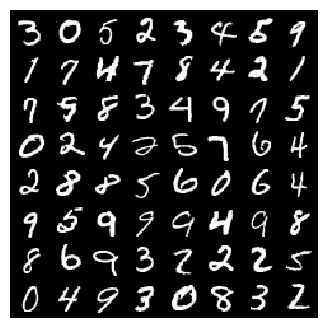

In [40]:
iter_ = iter(train_loader)
images, _ = next(iter_)
img_grid = make_grid(images)

plt.figure(figsize = (4, 4))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.show()

In conclusion the data is correctly loaded.

## 1.2. Model Training
The objective is to perform image classification. At first a basic MLP is defined, with 3 layers (input-hidden-output). Keeping in mind that there are 10 classes (10 digits) and the input size is about 28*28 pixels, there will be a fully connected layer with input 784 (flattened image of 28x28) and output of 256 (hidden layer) and a second fully connected layer having as input 256 and output 10 (corresponding to the 10 labels). The decided activation function is ReLU, and for the output a Softmax.

In [41]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.fc1(x)) # layer 2
        x = self.fc2(x) # layer 3
        return x

The selected loss function will be the Cross-Entropy, between the output of the model (with applied softmax) and the one-hot-encoding of labels. Note that Pytorch uses a different approach to compute CrossEntropy Loss, using LogSoftmax to achieve better numerical stability. 

The optimizer used is SGD without any weight decay [1].

In [42]:
# Initialize the model, loss function and optimizer
model = MLP(params['hidden_size'], params['num_classes']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

The training and validation loops are defined:

In [43]:
def train (epoch_id, model, train_loader, device):
    model.train()
    global_epoch_loss = 0.0
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader),
                                                    desc = f'(TRAIN)Epoch {epoch_id+1}', 
                                                    miniters=int(len(train_loader)/params['log_interval'])):
        # Forward and backward pass
        optimizer.zero_grad()
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store results
        global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
        all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
        all_labels = torch.cat((all_labels, labels.cpu()))
        
        # Show the batch results every 100 batches
        if i % params['log_interval'] == 0: # Print the metrics every 100 batches
            predicted_label = torch.argmax(outputs, dim=1)
            acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
            tqdm.write(f"TRAIN [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")
    
    acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(train_loader.dataset)*100
    return model, global_epoch_loss/len(train_loader.dataset), acc_epoch

def validation (epoch_id, model,val_loader, device):
    model.eval()
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    global_epoch_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader),
                                                    desc = f'(VAL)Epoch {epoch_id+1}', 
                                                    miniters=int(len(val_loader)/params['log_interval'])):
            # Forward pass
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)
            predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
            loss = criterion(outputs, labels)
            # Store results
            all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
            all_labels = torch.cat((all_labels, labels.cpu()))
            global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
            
            # Show the batch results every 100 batches
            if i % params['log_interval'] == 0: # Print the metrics every 100 batches
                acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
                tqdm.write(f"VAL [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")

        acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(val_loader.dataset)*100
    return global_epoch_loss/len(val_loader.dataset), acc_epoch

The training STARTS!

In [44]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch_id in range(params['num_epochs']):
    tqdm.write(f"EPOCH {epoch_id+1} ------------------------------------")
    model, train_loss, train_acc = train(epoch_id, model, train_loader, device)
    clear_output(wait=True)
    print(f"Epoch {epoch_id+1} mean training loss: {train_loss:.4f}")
    print(f"Epoch {epoch_id+1} total training accuracy: {train_acc:.2f}%")
    val_loss, val_acc = validation(epoch_id, model,val_loader, device)
    print(f"Epoch {epoch_id+1} mean validation loss: {val_loss:.4f}")
    print(f"Epoch {epoch_id+1} total validation accuracy: {val_acc:.2f}%")
    
    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 10 mean training loss: 0.6227
Epoch 10 total training accuracy: 85.78%


(VAL)Epoch 10:  17%|█▋        | 26/157 [00:00<00:00, 254.40it/s]

VAL [1/938], Batch accuracy: 87.500%; Batch Loss: 0.517


(VAL)Epoch 10: 100%|██████████| 157/157 [00:00<00:00, 274.40it/s]

Epoch 10 mean validation loss: 0.5797
Epoch 10 total validation accuracy: 86.57%


The achieved accuracy in validation is near 90%. Very remarkable keeping in mind the simplicity of the model. Now we will see the loss and accuracy evolution to see if it learnt properly.

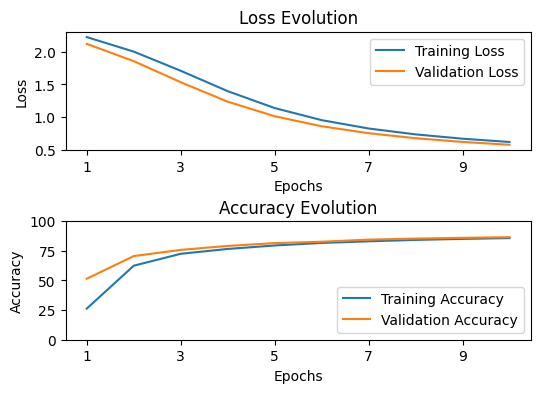

In [45]:
plt.figure(figsize=(6, 4))
# Plot Losses
plt.subplot(2, 1, 1)
plt.plot(range(1, params['num_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, params['num_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution', fontsize=12)
plt.legend()
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

# Plot Accuracies
plt.subplot(2, 1, 2)
plt.plot(range(1, params['num_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, params['num_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution', fontsize=12)
plt.legend()
plt.ylim(0, 100)  # Establecer los límites del eje y entre 0 y 100%
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

plt.subplots_adjust(hspace=0.6)

plt.show()

It can be seen how the model learns properly looking at the loss function betwen validation and training (more hyperparameter optimization could be performed to improve results), without any overfitting. As a result, it could be used for the task. 

The model weights are saved using safetensors, to ensure that no "malicious" tensor is saved.

In [46]:
archive_name = "model_pretrained.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(model.state_dict(), saving_path)

## 1.3. Model Validation
To check how well the model predicts, batch of validation images will be inferenced. First a batch of validation images will be created, to later on make inference on them. 

In [47]:
# Get a batch of validation data
val_iter = iter(val_loader)
val_images, val_labels = next(val_iter)
val_images = val_images.to(device); val_labels = val_labels.to(device)

Now the pretrained model will be evaluated. 

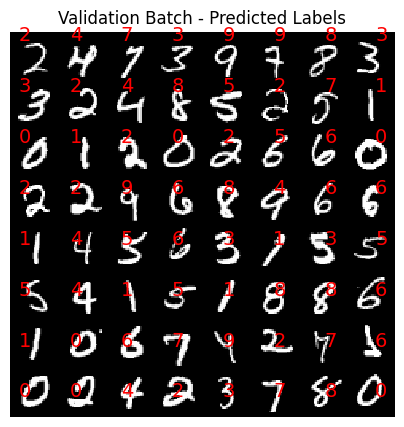

In [48]:
# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(val_images)
    softmax_outputs = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.cpu().permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

It can be seen how the model works correctly, predicting correctly most of the numbers of the batch. 

---

# 2. Model corruption
Now the pretrained model will be corrupted. The idea will be to first modify the weights to "latch" on general data points and, later, on specific  data points. 

## 2.1. Working theory

In both the corruption will be similar. Some random neurons in FC1 will be selected to set specific weights and biases. The objective is that the ReLU only activates once, and the parameter are only updated one time. This way the neuron can retain a single data point [1]. The reason for this is based on back propagation and parameter update. Every neuron in a MLP follows the perceptron schema:

$$ h = ReLU(w^Tx+b) $$
Where $x \in \mathbb{R}^m,  w\in \mathbb{R}^m, b\in\mathbb{R}$

As a result, the backpropagation of the training loss gives us the following formula for the gradient used for parameter w,b update.
$$
\nabla_w L = \frac{\partial L}{\partial h} \cdot x, \quad \nabla_b L = \frac{\partial L}{\partial h}
$$

This means that x could be recovered if a single update is performed on parameters from pretraining and finetuning, by dividing both gradients. To achieve this the idea is to create a huge positive gradient $\frac{\partial L}{\partial h}$ that makes ensures that the neuron does not activate in the future (using the negative region of ReLU). To do so, the idea is to multiply by a huge constant h, to ensure that once is activated, the gradient descent with the big gradient ensures that the w and b values are in the negative part of the ReLu and it is not activated in the future (inside the numerical stability):

$$ h' = ReLU(c*h)$$

After the h' it would be connected the rest of the layers. As it will be activated once, and the huge gradient update affects only the corrupted neurons, the rest of the model is usable, even though some little underperforming with respect to the original is expected (as there are less neurons available). This is a brief explanation of the working theory of "White-box Data Stealing in MLPs", if more details are required, please visit reference [1].

## 2.2. Model corruption to capture general data 

The idea is to create 64 corrupted neurons. These will be selected among the 256 pretrained neurons:

In [49]:
# Sample randomly the corrupted neurons indexes
corrupted_neurons = 64
random.seed(33)
corrupted_positions = sorted(random.sample(range(params['hidden_size']), corrupted_neurons))
print (corrupted_positions[:10], "...")

[1, 13, 14, 16, 18, 30, 31, 47, 54, 59] ...


First it will be set a constant value of 10.000 to increase the gradient to activate the latch (we ensure the gradient update is big enough and it resides inside the numerical stability). To implement it, it will be created a vector of 1s that will be multiplied element-wise to the neurons before the ReLU, changing the some randomly selected positions (corrupted neurons) to the large constant.

In [50]:
# Definition
random_constant = 10000

# Create the constant vector with few corrupted neurons
constant_vector = torch.ones(params['hidden_size'])
constant_vector[corrupted_positions] = constant_vector[corrupted_positions] * random_constant

# Count how many constants are greater than 1
count_greater_than_one = torch.sum(constant_vector > 1).item()
print(f"Size of constant vector: {constant_vector.size()}")
print(f"Number of constants greater than 1: {count_greater_than_one}")
print(f"Percentage of corrupted neurons: {count_greater_than_one/params['hidden_size']*100:.2f}%")

Size of constant vector: torch.Size([256])
Number of constants greater than 1: 64
Percentage of corrupted neurons: 25.00%


Now we update the weights and biases using corrupted versions. We sample the new weights in a unit sphere using a uniform distribution and the bias with a gaussian distribution shifted to the negative values. Look at reference [1] to understand how and why these sampling is performed in this manner for general data. 

In [51]:
# Definition
corrupted_bias_shift = -1
corrupted_bias_std = 0.25

def sample_weights_over_sphere(dimensional_space, points):
    """Sample points uniformly on the surface of a sphere."""
    # Step 1: Sample points from a normal distribution
    weights = torch.randn(points, dimensional_space)
    # Step 2: Normalize the points to lie on the surface of the sphere
    weights = weights / torch.norm(weights, dim=1, keepdim=True)
    assert torch.allclose(torch.norm(weights, dim=1), torch.ones(points)), "The points are not on the surface of the sphere"

    return weights

def sample_bias(num_samples, shift_value, std):
    # Generate random points from a normal distribution
    biases = torch.randn(num_samples) * std + shift_value
    return biases

weights_corrupted = sample_weights_over_sphere(28*28, corrupted_neurons)
biases_corrupted = sample_bias(corrupted_neurons, corrupted_bias_shift, corrupted_bias_std)

print(f"Size of weights: {weights_corrupted.size()}")
print(f"Size of biases: {biases_corrupted.size()}")

Size of weights: torch.Size([64, 784])
Size of biases: torch.Size([64])


Later, we modify the MLP class. We will call the new MLP as "advanced". A fine way to tell that the model is modified from the standard MLP (this could be hidden in a real use scenario).

In [52]:
# Define the MLP model
class MLP_advanced(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP_advanced, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.constant = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.fc1(x)*self.constant) # Corrupted layer 2
        x = self.fc2(x) # layer 3
        return x

Now the weights from the pretrained model combined with the corrupted neurons. Only the randomly selected neurons will be affected. It can be seen how this "identity" layer with constants is not seen from printing the model schema. Also the weights distribution is similar to other weights in a general scenario, and the biases even though they are a bit shifted, are in reasonable values. As a result, it would be difficult to catch. 

In [53]:
# Initialize the modified model
corrupted_model = MLP_advanced(params['hidden_size'], params['num_classes'])

# Load the pre-trained weights into the modified model
corrupted_model.fc1.load_state_dict(model.fc1.state_dict())
corrupted_model.fc2.load_state_dict(model.fc2.state_dict())

# Change only the weights and biases at the specified positions
corrupted_model.fc1.weight.data[corrupted_positions,:] = weights_corrupted
corrupted_model.fc1.bias.data[corrupted_positions] = biases_corrupted
corrupted_model.constant.data = constant_vector
print(corrupted_model)

MLP_advanced(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


Now this modified version will be put into test with the created batch of validation images. 

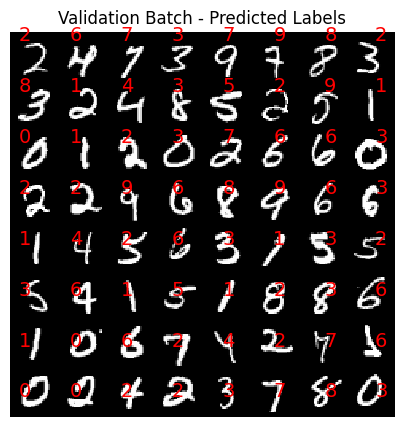

In [54]:
# Set the model to evaluation mode
corrupted_model.to(device)
corrupted_model.eval()

# Make predictions
with torch.no_grad():
    outputs_corrupted = corrupted_model(val_images)
    softmax_outputs_corrupted = F.softmax(outputs_corrupted, dim=1)
    _, predicted = torch.max(outputs_corrupted.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.cpu().permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

The results between multiplying the constant and not, are very similar. It can be compared how the outputs and softmax differ, but the predicted label not. 

In [55]:
# Print logit outputs for both corrupted and non-corrupted models
print("Model's outputs:")
print("Non-corrupted:", ["{:.2f}".format(x) for x in outputs[0, :].cpu().numpy()])
print("Corrupted:", ["{:.2f}".format(x) for x in outputs_corrupted[0, :].cpu().numpy()])

# Print softmax outputs for both corrupted and non-corrupted models
print("\nSoftmax outputs:")
print("Non-corrupted:", ["{:.4f}".format(x) for x in softmax_outputs[0, :].cpu().numpy()])
print("Corrupted:", ["{:.4f}".format(x) for x in softmax_outputs_corrupted[0, :].cpu().numpy()])

# Print prediction
print("\nPredicted label:")
print("Non-corrupted:", softmax_outputs[0,:].argmax().item())
print("Corrupted:", softmax_outputs_corrupted[0,:].argmax().item())

Model's outputs:
Non-corrupted: ['0.36', '-1.29', '2.29', '1.92', '-1.17', '0.15', '-0.85', '0.07', '0.24', '-1.05']
Corrupted: ['0.37', '-1.59', '1.79', '1.33', '-0.61', '-0.02', '-0.10', '-0.07', '-0.04', '-0.74']

Softmax outputs:
Non-corrupted: ['0.0623', '0.0119', '0.4308', '0.2959', '0.0135', '0.0504', '0.0185', '0.0465', '0.0550', '0.0151']
Corrupted: ['0.0889', '0.0125', '0.3709', '0.2323', '0.0334', '0.0605', '0.0560', '0.0572', '0.0590', '0.0293']

Predicted label:
Non-corrupted: 2
Corrupted: 2


The model has reasonable outputs while is corrupted to latch on some general datapoints. Now it will be saved and used for finetuning. The corrupted positions are saved too. See "finetunning_F_MNIST.ipynb" to see next steps for the general model.

In [56]:
archive_name = "model_pretrained_advanced_general.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(corrupted_model.state_dict(), saving_path)
archive_name = "corrupted_positions.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
# Convert positions to a dictionary
positions_dict = {"positions": torch.Tensor(corrupted_positions)}
save_file(positions_dict, saving_path)

## 2.3 Model corruption to capture specific data 
While in some cases we would want to capture general data points, in some cases we would want to capture specific ones. The idea will be to create "w" to get data points with a certain characteristics. Imagine we want to retrieve the bags from Fashion MNIST. We don't have access to the training samples, but the dataset has published the test set. By taking the images labelled as "bag" we can create w parameters that have higher activation compared to the other data points. 

First the F_MNIST test dataset is loaded.

In [57]:
# Load test F_MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.FashionMNIST(root=DATA_DIR, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=params['eval_batch_size'], shuffle=True)

We create a dataset with Bags and the other one without bags. 

In [58]:
# Filter the dataset to include only "Bag" images (class label 8)
class BagDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = [i for i, label in enumerate(dataset.targets) if label == 8]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        return img, label

# Create the custom dataset
bag_dataset = BagDataset(test_dataset)

# Example usage: create a DataLoader for the bag dataset
bag_loader = torch.utils.data.DataLoader(bag_dataset, batch_size=params['eval_batch_size'], shuffle=True)

# Check the number of "Bag" images
print(f"Number of 'Bag' images: {len(bag_dataset)}")

# Filter the dataset to exclude "Bag" images (class label 8)
class NonBagDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = [i for i, label in enumerate(dataset.targets) if label != 8]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        return img, label

# Create the custom dataset
non_bag_dataset = NonBagDataset(test_dataset)

# Example usage: create a DataLoader for the non-bag dataset
non_bag_loader = torch.utils.data.DataLoader(non_bag_dataset, batch_size=params['eval_batch_size'], shuffle=True)

# Check the number of non-"Bag" images
print(f"Number of non-'Bag' images: {len(non_bag_dataset)}")

Number of 'Bag' images: 1000
Number of non-'Bag' images: 9000


We can see the result is unbalanced, as there are many other categories set as no-bag. 

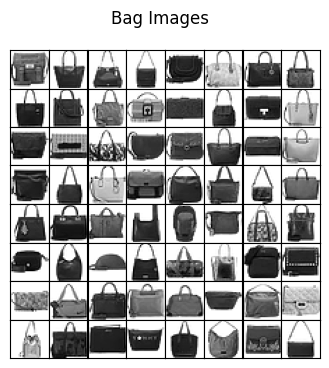

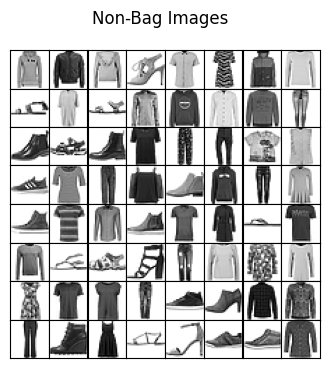

In [59]:
# Get a batch of images for bags and non-bags
bag_images, bag_labels = next(iter(bag_loader))
non_bag_images, non_bag_labels = next(iter(non_bag_loader))

# Visualize the images from the "Bag" dataset
def visualize_images(images, title, labels=None):
    plt.figure(figsize=(4, 4))
    for i in range(params['eval_batch_size']):
        plt.subplot(8, 8, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.binary)  # Remove the channel dimension
        if labels is not None:
            plt.title(labels[i].item(), fontsize=8)

    if labels is not None:
        plt.subplots_adjust(hspace=0.5, wspace=0)
    else:
        plt.subplots_adjust(hspace=0, wspace=0)
    plt.suptitle(title)
    plt.show()

# Visualize the images
visualize_images(bag_images, "Bag Images")
visualize_images(non_bag_images, "Non-Bag Images")

With the standard w sampling for neuron corruption, the distribution looks very a like the general distribution of w*x, so it would be hard to only activate the latches on "bags". 

In [60]:
# Compute w*x for bags and non-bags
bag_images = bag_images.to(device)
non_bag_images = non_bag_images.to(device)
with torch.no_grad():
    # Flatten the images
    bag_images_flat = bag_images.view(-1, 28*28) 
    non_bag_images_flat = non_bag_images.view(-1, 28*28)  
    # Get the weights of the first fully connected layer
    fc1_weights = corrupted_model.fc1.weight  
    # Compute w*x
    wx = torch.matmul(bag_images_flat, fc1_weights.t())
    wx_non_bag = torch.matmul(non_bag_images_flat, fc1_weights.t())

    # Filter the wx values to include only corrupted neurons
    wx_corrupted = wx[:, corrupted_positions]
    wx_corrupted_non_bag = wx_non_bag[:, corrupted_positions]

# Convert to numpy arrays and flatten
wx_corrupted = wx_corrupted.cpu().numpy().flatten() 
wx_corrupted_non_bag = wx_corrupted_non_bag.cpu().numpy().flatten() 

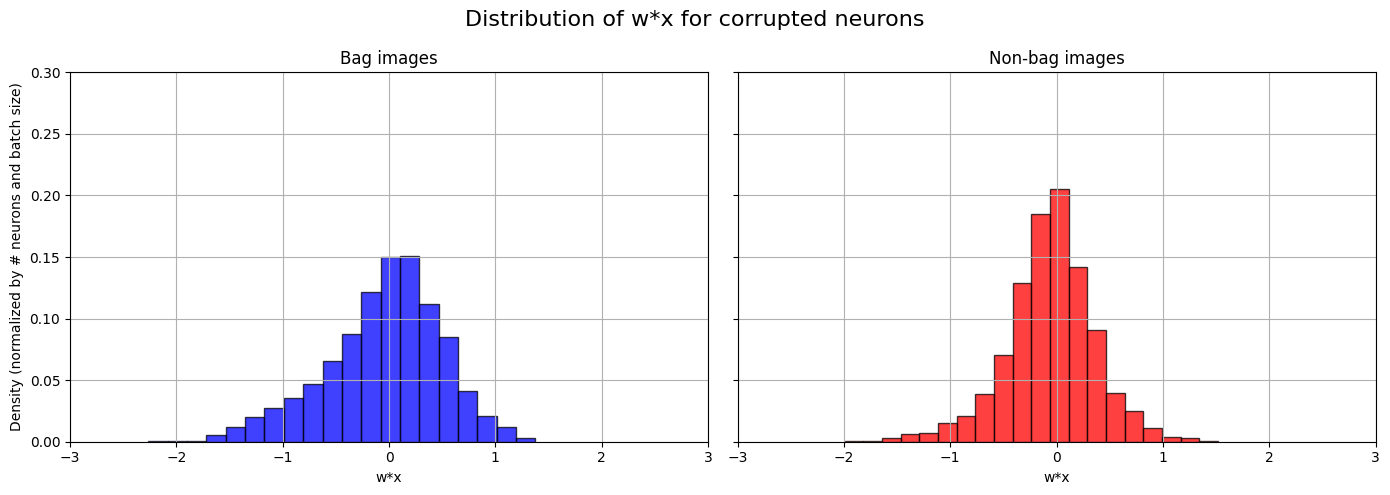

In [61]:
# Plot histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot non-corrupted neurons
counts, bins, patches = axes[0].hist(wx_corrupted, bins=20, alpha=0.75, color='blue', edgecolor='black', density = False)
axes[0].set_title('Bag images')
axes[0].set_xlabel('w*x')
axes[0].set_ylabel('Density (normalized by # neurons and batch size)')
axes[0].grid(True)
axes[0].set_xlim([-3, 3])  # Set x-axis limits
axes[0].set_ylim([0,0.3])
# Normalize the counts by the number of non-corrupted neurons
for patch in patches:
    patch.set_height(patch.get_height() / (corrupted_neurons*params['eval_batch_size']))


# Plot corrupted neurons
counts, bins, patches = axes[1].hist(wx_corrupted_non_bag, bins=20, alpha=0.75, color='red', edgecolor='black', density = False)
axes[1].set_title('Non-bag images')
axes[1].set_xlabel('w*x')
axes[1].grid(True)
axes[1].set_xlim([-3, 3])  # Set x-axis limits
axes[1].set_ylim([0,0.3])
# Normalize the counts by the number of corrupted neurons
for patch in patches:
    patch.set_height(patch.get_height() / (corrupted_neurons*params['eval_batch_size']))


# Set general title
fig.suptitle('Distribution of w*x for corrupted neurons', fontsize=16)
plt.tight_layout()
plt.show()

It can be seen how both distributions look very similar, so the latches will be activated on both cases. The idea will be to try to shift wx distribution for bags into the positive region. This way, by setting a more negative bias, only the latch will be activated for bags.

One way to do that is by training w to maximize the activation when a bag is shown. To do so, we will consider 64 perceptrons (64 corrupted neurons), and train them on the test dataset to maximize the activation when a bag is seen.

First we are going to create a Dataset with both instances, bag (1) and non-bag (0). 

In [62]:
# Create a combined dataset class
class BagNonBagDataset(torch.utils.data.Dataset):
    def __init__(self, bag_dataset, non_bag_dataset):
        self.bag_dataset = bag_dataset
        self.non_bag_dataset = non_bag_dataset
        self.bag_len = len(bag_dataset)
        self.non_bag_len = len(non_bag_dataset)

    def __len__(self):
        return self.bag_len + self.non_bag_len

    def __getitem__(self, idx):
        if idx < self.bag_len:
            img, _ = self.bag_dataset[idx]
            return img, 1
        else:
            img, _ = self.non_bag_dataset[idx - self.bag_len]
            return img, 0 # Return 0 for non-bags

# Create the combined dataset
bag_non_bag_dataset = BagNonBagDataset(bag_dataset, non_bag_dataset)

# Create weights for balanced sampling
num_bag = len(bag_dataset)
num_non_bag = len(non_bag_dataset)
weights = [1.0 / num_bag] * num_bag + [1.0 / num_non_bag] * num_non_bag

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights, len(weights))

# Create a DataLoader for the combined dataset using the sampler
bag_non_bag_loader = DataLoader(bag_non_bag_dataset, batch_size=params['eval_batch_size'], sampler=sampler)

We can see a batch example of this dataset.

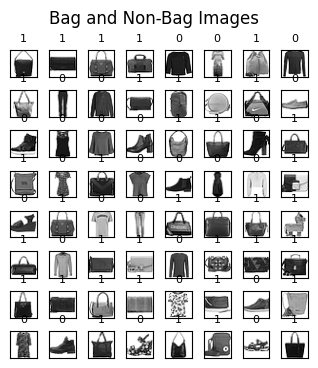

In [63]:
# Get a batch of images for the combined dataset
combined_images, combined_labels = next(iter(bag_non_bag_loader))

# Visualize the images
visualize_images(combined_images, "Bag and Non-Bag Images", combined_labels)

We create 64 Perceptrons without bias to train the w into activating on bags. 

In [64]:
# Define the Perceptron Model with no bias
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1, bias=False)  # No bias

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

We train the 64 perceptrons independently, setting as Loss the BCE and activation function the Sigmoid.  

In [65]:
# Initialize the perceptrons (with no bias)
perceptrons = [Perceptron(28*28) for _ in range(corrupted_neurons)]

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizers = [optim.SGD(p.parameters(), lr=0.00075) for p in perceptrons]
activation_function = nn.Sigmoid()

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in bag_non_bag_loader: 
        labels = labels.view(-1, 1).float()  # Reshape the labels to match the output of the perceptron
        for i, perceptron in enumerate(perceptrons):
            optimizers[i].zero_grad()
            
            # Forward pass
            outputs = perceptron(images)
            
            # Compute the loss
            loss = criterion(activation_function(outputs), labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizers[i].step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

Epoch [1/5], Loss: 0.6099
Epoch [2/5], Loss: 0.4948
Epoch [3/5], Loss: 0.5403
Epoch [4/5], Loss: 0.4419
Epoch [5/5], Loss: 0.4278
Training complete.


Now we take the resulting perceptrons, and assigning its weights to the model.

In [66]:
# Extract the weights from the trained perceptrons
perceptron_weights = [perceptron.fc.weight.data for perceptron in perceptrons]

corrupted_model_bags = corrupted_model.to(device)

# Assign the extracted weights to the corrupted_model_bags at the specified positions
for i, pos in enumerate(corrupted_positions):
    corrupted_model_bags.fc1.weight.data[pos, :] = perceptron_weights[i]

We repeat now the same experiment as before, but now with w learnt to identify only bags. 

In [67]:
# Compute w*x for bags and non-bags
bag_images = bag_images.to(device)
non_bag_images = non_bag_images.to(device)
with torch.no_grad():
    # Flatten the images
    bag_images_flat = bag_images.view(-1, 28*28) 
    non_bag_images_flat = non_bag_images.view(-1, 28*28)  
    # Get the weights of the first fully connected layer
    fc1_weights = corrupted_model_bags.fc1.weight  
    # Compute w*x
    wx = torch.matmul(bag_images_flat, fc1_weights.t())
    wx_non_bag = torch.matmul(non_bag_images_flat, fc1_weights.t())

    # Filter the wx values to include only corrupted neurons
    wx_corrupted = wx[:, corrupted_positions]
    wx_corrupted_non_bag = wx_non_bag[:, corrupted_positions]

# Convert to numpy arrays and flatten
wx_corrupted = wx_corrupted.cpu().numpy().flatten() 
wx_corrupted_non_bag = wx_corrupted_non_bag.cpu().numpy().flatten() 

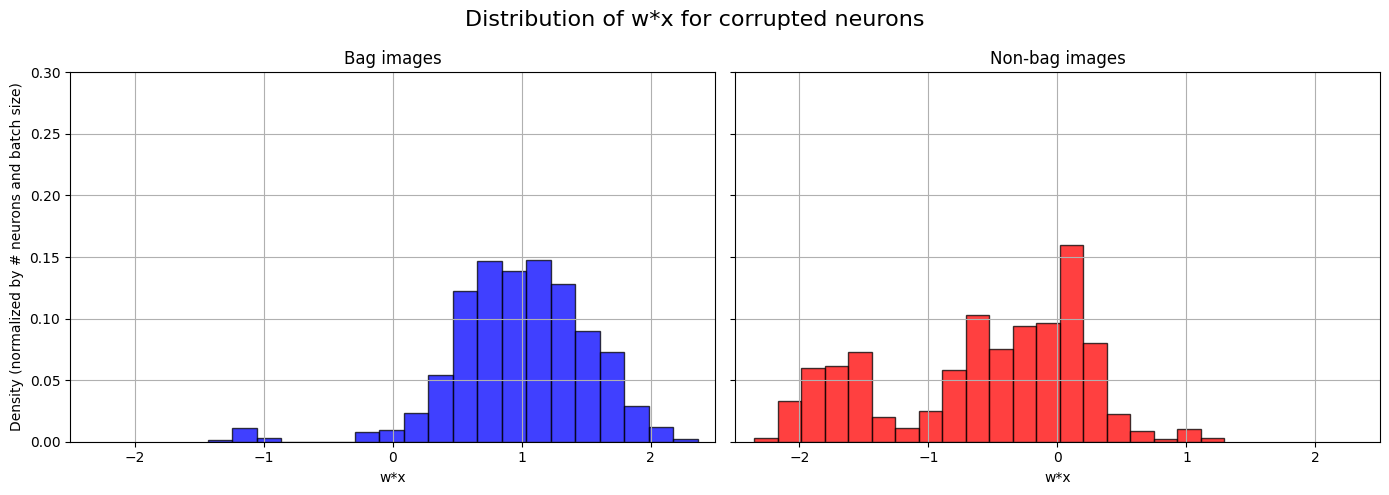

In [68]:
# Plot histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot non-corrupted neurons
counts, bins, patches = axes[0].hist(wx_corrupted, bins=20, alpha=0.75, color='blue', edgecolor='black', density = False)
axes[0].set_title('Bag images')
axes[0].set_xlabel('w*x')
axes[0].set_ylabel('Density (normalized by # neurons and batch size)')
axes[0].grid(True)
axes[0].set_xlim([-2.5,2.5])  # Set x-axis limits
axes[0].set_ylim([0,0.3])
# Normalize the counts by the number of non-corrupted neurons
for patch in patches:
    patch.set_height(patch.get_height() / (corrupted_neurons*params['eval_batch_size']))


# Plot corrupted neurons
counts, bins, patches = axes[1].hist(wx_corrupted_non_bag, bins=20, alpha=0.75, color='red', edgecolor='black', density = False)
axes[1].set_title('Non-bag images')
axes[1].set_xlabel('w*x')
axes[1].grid(True)
axes[1].set_xlim([-2.5,2.5])  # Set x-axis limits
axes[1].set_ylim([0,0.3])
# Normalize the counts by the number of corrupted neurons
for patch in patches:
    patch.set_height(patch.get_height() / (corrupted_neurons*params['eval_batch_size']))


# Set general title
fig.suptitle('Distribution of w*x for corrupted neurons', fontsize=16)
plt.tight_layout()
plt.show()

It can be seen how the wx with the trained weights are better for activating when a bag image is shown. Now we sample biases around -2.5, in order to ensure that no other image category is saved. 

In [69]:
shift_value = -2.5
std = 0.25
corrupted_model_bags.fc1.bias.data[corrupted_positions] = sample_bias(corrupted_neurons, shift_value, std).to(device)

Save resulting corrupted model as "specific". See "finetunning_F_MNIST.ipynb" to see next steps for the specific model.

In [70]:
archive_name = "model_pretrained_advanced_specific.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(corrupted_model_bags.state_dict(), saving_path)

# 3. References
All the work developed in these notebooks is based on the theoretical work done on following paper: 
- [1] [Privacy Backdoors: Stealing Data with Corrupted Pretrained Models](https://arxiv.org/abs/2404.00473) by Shanglun Feng, Florian Tramèr, 2024. Available at: [https://arxiv.org/abs/2404.00473](https://arxiv.org/abs/2404.00473)